In [1]:
import os
os.chdir('/home/yash/Desktop/tensorflow-adversarial/tf_example')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import numpy as np
import tensorflow as tf
from tensorflow.contrib.learn import ModeKeys, Estimator
import _pickle as pickle
from scipy.misc import imread
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from fgsm_cifar import fgsm
from fgsm_cifar_wrt_class import fgsm_wrt_class
import mnist
import sys  

img_rows = 32
img_cols = 32
img_chas = 3
input_shape = (img_rows, img_cols, img_chas)
n_classes = 10

def load_CIFAR10(ROOT):
  """ load all of cifar """
  xs = []
  ys = []
  for b in range(1,6):
    f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
    X, Y = load_CIFAR_batch(f)
    xs.append(X)
    ys.append(Y)    
  Xtr = np.concatenate(xs)
  Ytr = np.concatenate(ys)
  del X, Y
  Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
  return Xtr, Ytr, Xte, Yte

def load_CIFAR_batch(filename):
  """ load single batch of cifar """
  with open(filename, 'rb') as f:
    datadict = pickle.load(f,encoding='latin1')
    X = datadict['data']
    Y = datadict['labels']
    X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
    Y = np.array(Y)
    return X, Y

def find_l2_batch(X_test, X_adv):
    ans = np.zeros([X_test.shape[0],n_classes], dtype = np.float32)
    for i in range(X_test.shape[0]):
        for j in range(n_classes):
            ans[i][j] = find_l2(X_test[i], X_adv[i][j])
    return ans


# m2 is the grouped flipping
# m1 is the single flipping
#This method returns the distance of each predictions from repective test points calculated by m1 and m2 resp. 
def find_m1_m2(X_test,X_adv_one,X_adv_test):
    dist_adv_m1 = find_l2(X_test, X_adv_one)
    b = find_l2_batch(X_test, X_adv_test)
    dist_adv_m2 = np.partition(b,axis=1,kth=1)[:,1]
    return np.sqrt(dist_adv_m1), np.sqrt(dist_adv_m2)

# Give this function X_adv_test it gives you the points corresponding to
# each example having min dists and their indices 

def give_m2_ans(X_test, X_adv_test):
    dists = find_l2_batch(X_test, X_adv_test)
    second_min_indices = np.partition(dists, axis=1, kth=1)[:,1]
    for i in range(X_test.shape[0]):
        second_min_indices[i] = np.where(second_min_indices[i] == dists[i])[0]
    return second_min_indices, X_adv_test[second_min_indices.astype(int)]

def random_normal_func(X, n):
    X=X.reshape(-1,img_rows*img_cols*img_chas)
    print(X.shape)
    mean, std = np.mean(X, axis=0), np.std(X,axis=0)
    randomX = np.zeros([n,X[0].size])
    print(randomX.shape)
    for i in range(X[0].size):
        randomX[:,i] = np.random.normal(mean[i],std[i],n)
    randomX = randomX.reshape(-1,img_rows,img_cols,img_chas)
    ans = sess.run(env.ybar, feed_dict={env.x: randomX,env.training: False})
    labels = _to_categorical(np.argmax(ans,axis=1), n_classes)
    return randomX,labels

def remove_zeroes(X):
    indices = np.where(X == 0)[0]
    return np.delete(X,indices)

def get_class(X,Y,cls):
    Y=np.argmax(Y, axis=1)
    indices = np.where(Y==cls)
    return X[indices], Y[indices]

def get_flipped_class(X_adv,cls):
    return X_adv[:,cls]

In [2]:
print('\nLoading CIFAR10')
ab=sys.getdefaultencoding()
print(ab)
cifar10_dir = 'cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

X_train = X_train.reshape(-1, img_rows, img_cols, img_chas)
X_test = X_test.reshape(-1, img_rows, img_cols, img_chas)

# X_train=X_train[:100]
# y_train=y_train[:100]


Loading CIFAR10
utf-8


In [3]:
# one hot encoding, basically creates hte si
def _to_categorical(x, n_classes):
    x = np.array(x, dtype=int).ravel()
    n = x.shape[0]
    ret = np.zeros((n, n_classes))
    ret[np.arange(n), x] = 1
    return ret

def find_l2(X_test, X_adv):
    a=X_test.reshape(-1,32*32*3)
    b=X_adv.reshape(-1,32*32*3)
    l2_unsquared = np.sum(np.square(a-b),axis=1)
    return l2_unsquared

y_train = _to_categorical(y_train, n_classes)
y_test = _to_categorical(y_test, n_classes)
print('\nShuffling training data')
ind = np.random.permutation(X_train.shape[0])
X_train, y_train = X_train[ind], y_train[ind]

# split training/validation dataset
validation_split = 0.1
n_train = int(X_train.shape[0]*(1-validation_split))
X_valid = X_train[n_train:]
X_train = X_train[:n_train]
y_valid = y_train[n_train:]
y_train = y_train[:n_train]

class Dummy:
    pass
env = Dummy()



Shuffling training data
The history saving thread hit an unexpected error (OperationalError('database is locked',)).History will not be written to the database.


In [4]:
print (X_test.shape)

(10000, 32, 32, 3)


In [5]:
def model(x, logits=False, training=False):
    conv0 = tf.layers.conv2d(x, filters=32, kernel_size=[3, 3],
                             padding='same', name='conv0',
                             activation=tf.nn.relu)
    
    pool0 = tf.layers.max_pooling2d(conv0, pool_size=[2, 2],
                                    strides=2, name='pool0')
    
    conv1 = tf.layers.conv2d(pool0, filters=64,
                             kernel_size=[3, 3], padding='same',
                             name='conv1', activation=tf.nn.relu)
   
 
    
    pool1 = tf.layers.max_pooling2d(conv1, pool_size=[2, 2],
                                    strides=2, name='pool1')
    
    conv2 = tf.layers.conv2d(pool1, filters=128,
                             kernel_size=[1,1], padding='same',
                             name='conv2', activation=tf.nn.relu)
    

    
    flat = tf.reshape(conv2, [-1, 8*8*128], name='flatten')
    
    dense1 = tf.layers.dense(flat, units= 1024, activation=tf.nn.relu,
                            name='dense1')
    
    dense2 = tf.layers.dense(dense1, units=128, activation=tf.nn.relu,
                            name='dense2')
    logits_ = tf.layers.dense(dense2, units=10, name='logits') #removed dropout
    
    y = tf.nn.softmax(logits_, name='ybar')
    
    if logits:
        return y, logits_
    return y


In [6]:
# We need a scope since the inference graph will be reused later
with tf.variable_scope('model'):
    env.x = tf.placeholder(tf.float32, (None, img_rows, img_cols,
                                        img_chas), name='x')
    env.y = tf.placeholder(tf.float32, (None, n_classes), name='y')
    env.training = tf.placeholder(bool, (), name='mode')

    env.ybar, logits = model(env.x, logits=True,
                             training=env.training)

    z = tf.argmax(env.y, axis=1)
    zbar = tf.argmax(env.ybar, axis=1)
    env.count = tf.cast(tf.equal(z, zbar), tf.float32)
    env.acc = tf.reduce_mean(env.count, name='acc')

    xent = tf.nn.softmax_cross_entropy_with_logits(labels=env.y,
                                                   logits=logits)
    env.loss = tf.reduce_mean(xent, name='loss')

extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

with tf.control_dependencies(extra_update_ops):
    env.optim = tf.train.AdamOptimizer(beta1=0.9, beta2=0.999, epsilon=1e-08,).minimize(env.loss) 


In [7]:
with tf.variable_scope('model', reuse=True):
    for i in range(n_classes):
        if(i==0):
            env.x_adv_wrt_class = (fgsm_wrt_class(model, env.x, i, step_size=.05, bbox_semi_side=10))
        else:
            x = (fgsm_wrt_class(model, env.x, i, step_size=.05, bbox_semi_side=10))
            env.x_adv_wrt_class = tf.concat([env.x_adv_wrt_class, x],axis=0)
    env.x_adv, env.all_flipped = fgsm(model, env.x, step_size=.05, bbox_semi_side=10) #epochs is redundant now!
    

In [8]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
sess.run(tf.local_variables_initializer())

In [9]:
def save_model(label):
    saver = tf.train.Saver()
    saver.save(sess,  './models/cifar/' + label)
    
def restore_model(label):
    saver = tf.train.Saver()
    saver.restore(sess, './models/cifar/' + label)

In [10]:
def _evaluate(X_data, y_data, env):
    print('\nEvaluating')
    n_sample = X_data.shape[0]
    batch_size = 128
    n_batch = int(np.ceil(n_sample/batch_size))
    loss, acc = 0, 0
    ns = 0
    for ind in range(n_batch):
        print(' batch {0}/{1}'.format(ind+1, n_batch), end='\r')
        start = ind*batch_size
        end = min(n_sample, start+batch_size)
        batch_loss, batch_count, batch_acc = sess.run(
            [env.loss, env.count, env.acc],
            feed_dict={env.x: X_data[start:end],
                       env.y: y_data[start:end],
                       env.training: False})
        loss += batch_loss*batch_size
        print('batch count: {0}'.format(np.sum(batch_count)))
        ns+=batch_size
        acc += batch_acc*batch_size
    loss /= ns
    acc /= ns
#     print (ns)
#     print (n_sample)
    print(' loss: {0:.4f} acc: {1:.4f}'.format(loss, acc))
    return loss, acc

In [11]:
def _predict(X_data, env):
    print('\nPredicting')
    n_sample = X_data.shape[0]
    batch_size = 128
    n_batch = int(np.ceil(n_sample/batch_size))
    yval = np.empty((X_data.shape[0], n_classes))
    for ind in range(n_batch):
        print(' batch {0}/{1}'.format(ind+1, n_batch), end='\r')
        start = ind*batch_size
        end = min(n_sample, start+batch_size)
        batch_y = sess.run(env.ybar, feed_dict={
            env.x: X_data[start:end], env.training: False})
        yval[start:end] = batch_y
    return yval

def train(label):
    print('\nTraining')
    n_sample = X_train.shape[0]
    batch_size = 128
    n_batch = int(np.ceil(n_sample/batch_size))
    n_epoch = 50
    for epoch in range(n_epoch):
        print('Epoch {0}/{1}'.format(epoch+1, n_epoch))
        for ind in range(n_batch):
            print(' batch {0}/{1}'.format(ind+1, n_batch), end='\r')
            start = ind*batch_size
            end = min(n_sample, start+batch_size)
            sess.run(env.optim, feed_dict={env.x: X_train[start:end],
                                           env.y: y_train[start:end],
                                           env.training: True})
        if(epoch%5 == 0):
            model_label = label+ '{0}'.format(epoch)
            print("saving model " + model_label)
            save_model(model_label)
            
    save_model(label)
    

In [12]:
def create_adv_wrt_class(X, Y, label):
    print('\nCrafting adversarial')
    n_sample = X.shape[0]
    pred = np.argmax(Y,axis=1)
    batch_size = 1
    n_batch = int(np.ceil(n_sample/batch_size))
    n_epoch = 20
    x_adv_shape = list(X.shape)[1:]
    x_adv_shape = np.append(np.append(n_sample,n_classes),x_adv_shape)
    X_adv = np.empty(x_adv_shape)
    for ind in range(n_batch):
        print(' batch {0}/{1}'.format(ind+1, n_batch), end='\r')
        start = ind*batch_size
        end = min(n_sample, start+batch_size)
        tmp = sess.run(env.x_adv_wrt_class, feed_dict={env.x: X[start:end],
                                             env.y: Y[start:end],
                                             env.training: False})
#         _evaluate(tmp, Y[start:end],env)
#         print (tmp.shape)
        tmp[pred[start]] = X[start]
        X_adv[start:end] = tmp
#         print(all_flipped)
    print('\nSaving adversarial')
    os.makedirs('data', exist_ok=True)
    np.save('data/cifar/' + label + '.npy', X_adv)
    return X_adv

In [13]:
def create_adv(X, Y, label):
    print('\nCrafting adversarial')
    n_sample = X.shape[0]
    batch_size = 1
    n_batch = int(np.ceil(n_sample/batch_size))
    n_epoch = 20
    X_adv = np.empty_like(X)
    for ind in range(n_batch):
        print(' batch {0}/{1}'.format(ind+1, n_batch), end='\r')
        start = ind*batch_size
        end = min(n_sample, start+batch_size)
        tmp, all_flipped = sess.run([env.x_adv, env.all_flipped], feed_dict={env.x: X[start:end],
                                             env.y: Y[start:end],
                                             env.training: False})
#         _evaluate(tmp, Y[start:end],env)
        X_adv[start:end] = tmp
#         print(all_flipped)
    print('\nSaving adversarial')
    os.makedirs('data', exist_ok=True)
    np.save('data/cifar/' + label + '.npy', X_adv)
    return X_adv

In [14]:
label="cifar_with_cnn"
# train(label) # else 
#Assuming that you've started a session already else do that first!
restore_model(label + '45')
# _evaluate(X_train, y_train, env)

INFO:tensorflow:Restoring parameters from ./models/cifar/cifar_with_cnn45


In [15]:
test_m1 = "test_fs_m1_e45"
test_m2 = "test_fs_m2_e45"
train_m1 = "train_fs_m1_e45"
train_m2 = "train_fs_m2_e45"
random_m1 = "random_fs_m1_e45"
random_m2 = "random_fs_m2_e45"
random_normal_m1= "random_normal_fs_m1_e45"
random_normal_m2 = "random_normal_fs_m2_e45"

n = 1000
X_test_sub = X_test[:n]
X_train_sub = X_train[:n]
y_train_sub = sess.run(env.ybar, feed_dict={env.x: X_train_sub,env.training: False})
y_train_sub = _to_categorical(np.argmax(y_train_sub, axis=1), n_classes)

y_test_sub = sess.run(env.ybar, feed_dict={env.x:X_test_sub ,env.training: False})
y_test_sub = _to_categorical(np.argmax(y_test_sub, axis=1), n_classes)

X_random = np.random.rand(n,img_rows,img_cols,img_chas)
X_random = X_random[:n]
y_random = sess.run(env.ybar, feed_dict={env.x: X_random,env.training: False})
y_random = _to_categorical(np.argmax(y_random, axis=1), n_classes)
X_random_normal, y_random_normal = random_normal_func(X_train,n)
 
X_adv_test_m1 = create_adv(X_test_sub, y_test_sub, test_m1)
X_adv_train_m1 = create_adv(X_train_sub, y_train_sub, train_m1)
X_adv_random_m1 = create_adv(X_random,y_random, random_m1)
X_adv_random_normal_m1 = create_adv(X_random_normal, y_random_normal, random_normal_m1)
    
    
# _, X_adv_test_m2 = give_m2_ans(X_test_sub, create_adv_wrt_class(X_test_sub, y_test_sub, test_m2))
# _, X_adv_train_m2 = give_m2_ans(X_train_sub, create_adv_wrt_class(X_train_sub, y_train_sub, train_m2))
# _, X_adv_random_m2 = give_m2_ans(X_random, create_adv_wrt_class(X_random, y_random, random_m2))
# _, X_adv_random_normal_m2 = give_m2_ans(X_random_normal, create_adv_wrt_class(X_random_normal, y_random_normal, random_normal_m2))


# print (X_adv_test_m1 == np.load('data/cifar/' + test_m1 + '.npy'))
# print(X_adv_train_m1 == np.load('data/cifar/' + train_m1 + '.npy'))
# X_adv_random_m1 = np.load('data/cifar/' + random_m1 + '.npy')
# X_adv_random_normal_m1 = np.load('data/cifar/' + random_normal_m1 + '.npy')

(45000, 3072)
(1000, 3072)

Crafting adversarial
 batch 1000/1000
Saving adversarial

Crafting adversarial
 batch 1000/1000
Saving adversarial

Crafting adversarial
 batch 1000/1000
Saving adversarial

Crafting adversarial
 batch 1000/1000
Saving adversarial


In [24]:
l2_test_m1 = find_l2(X_adv_test_m1,X_test_sub)
l2_train_m1 = find_l2(X_adv_train_m1, X_train_sub)
l2_random_m1 = find_l2(X_adv_random_m1,X_random)
l2_random_normal_m1 = find_l2(X_adv_random_normal_m1,X_random_normal)

In [26]:
if(1<2 and 3> 4):
    print('hi')

In [17]:
nz_test = np.count_nonzero(l2_test_m1)
nz_train = np.count_nonzero(l2_train_m1)
nz_random = np.count_nonzero(l2_random_m1)
nz_random_normal = np.count_nonzero(l2_random_normal_m1)

print (nz_test)
print (nz_train)
print (nz_random)
print (nz_random_normal)

l2_test_m1 = remove_zeroes(l2_test_m1)
l2_random_m1 = remove_zeroes(l2_random_m1)
l2_random_normal_m1 = remove_zeroes(l2_random_normal_m1)
l2_test_m1 = remove_zeroes(l2_test_m1)

min_no = min(nz_test, nz_train)
l2_train_m1 = np.sqrt(l2_train_m1[:min_no])
l2_test_m1 = np.sqrt(l2_test_m1[:min_no])
l2_random_m1 = np.sqrt(l2_random_m1[:min_no])
l2_random_normal_m1 = np.sqrt(l2_random_normal_m1[:min_no])


985
975
1000
1000


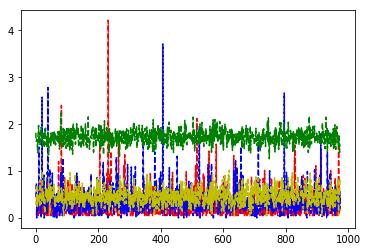

In [18]:
%matplotlib inline
# evenly sampled time at 200ms intervals
t = np.arange(1,min_no+1, 1)

# red dashes, blue squares and green triangles
plt.plot(t, l2_test_m1, 'r--', t, l2_train_m1, 'b--', t, l2_random_m1, 'y--', l2_random_normal_m1, 'g--')
plt.show()

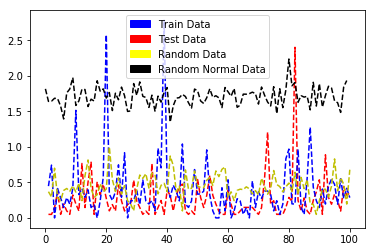

In [19]:
import matplotlib.patches as mpatches

%matplotlib inline
# evenly sampled time at 200ms intervals
t = np.arange(1,101, 1)

# red dashes, blue squares and green triangles
plt.plot(t, l2_test_m1[:100], 'r--', t, l2_train_m1[:100],'b--', t, l2_random_m1[:100], 'y--', l2_random_normal_m1[:100], 'k--')

blue_patch = mpatches.Patch(color='blue', label='Train Data')
red_patch = mpatches.Patch(color='red', label='Test Data')
yellow_patch = mpatches.Patch(color='yellow', label='Random Data')
black_patch = mpatches.Patch(color='black', label='Random Normal Data')

plt.legend(handles=[blue_patch, red_patch, yellow_patch, black_patch])

plt.show()

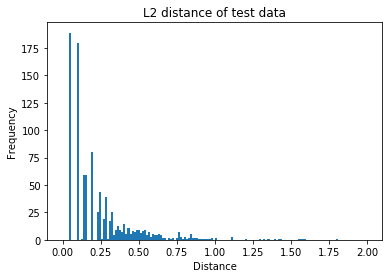

In [20]:
%matplotlib inline
plt.hist(l2_test_m1,150, range = (0,2))
plt.title("L2 distance of test data")
plt.xlabel("Distance")
plt.ylabel("Frequency")
plt.show()

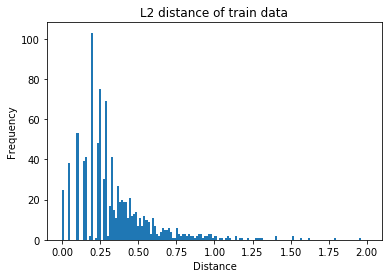

In [21]:
%matplotlib inline
plt.hist(l2_train_m1,150, range = (0,2))
plt.title("L2 distance of train data")
plt.xlabel("Distance")
plt.ylabel("Frequency")
plt.show()

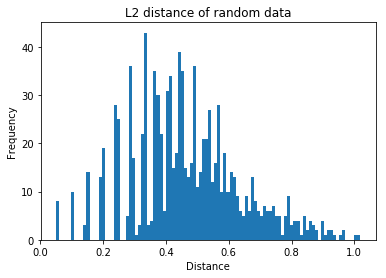

In [22]:
%matplotlib inline
plt.hist(l2_random_m1,100)
plt.title("L2 distance of random data")
plt.xlabel("Distance")
plt.ylabel("Frequency")
plt.show()

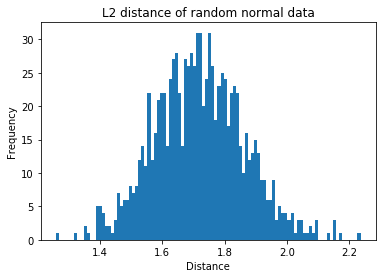

In [23]:
%matplotlib inline
plt.hist(l2_random_normal_m1,100)
plt.title("L2 distance of random normal data")
plt.xlabel("Distance")
plt.ylabel("Frequency")
plt.show()